In [17]:
# Required packages
using CSV
using DifferentialEquations
using OrdinaryDiffEq
using ODE
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using NLsolve
using Optim
pyplot();

In [2]:
# Loading csv file and accessing data of Ts, TFe, Tac, Tah
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end
# measurement data
data = [Ts_m TFe_m Tac_m Tah_m]'
# Subsampling measurements
idx = 1:15:N;

In [3]:
# While using coustom ODE we need to change simulation time to iteration to access data
# We define fucntion that change simulation time to iteration for input
# Inputs function given from data
function u_Ifd(t)
    # Iterative value of Ifd from real data
    t=trunc(Int,t/60+1)
    return If[t]
end
function u_It(t)
    # Iterative value of It from real data
    t=trunc(Int,t/60+1)
    return It[t]
end
function u_Twc(t)
    # Iterative value of Twc from real data
    t=trunc(Int,t/60+1)
    return Twc[t]
end


u_Twc (generic function with 1 method)

In [13]:
# Model 1
function gen(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o = 1.012,4.1813,0.385,0.412,28. 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*chpCu)
    du[2] = (3*Rs*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*chpCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*chpFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe = 1.012,4.1813,0.385,0.412 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
prob = ODEProblem(gen,u0,tspan,p)
sol = solve(prob, Euler(), dt=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)

3×584 Array{Float64,2}:
 13.1364  13.1829  13.2396  13.3007  …  18.0686  18.0665  18.0644  18.0622
 21.216   21.3047  21.4012  21.5003     27.6834  27.6797  27.6761  27.6722
 23.5328  23.6313  23.7513  23.8806     33.971   33.9665  33.962   33.9573

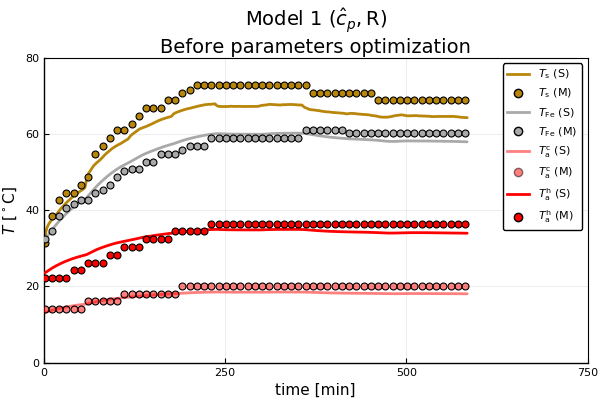

In [14]:
idx = 1:10:N
# Plotting simulation versus measurement data for Model 1
plt = plot()
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1before=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

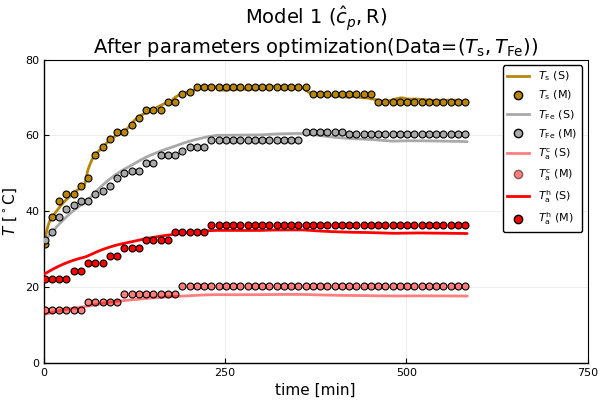

In [9]:
# Using data = (Ts, TFe) only
dataTwo = [data[1,:] data[2,:]]'
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,dt,dataTwo)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model1 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

# setting optimized parameter and solving ODE
p = res_model1.minimizer
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1afterUsingDataTsTFe=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$))",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

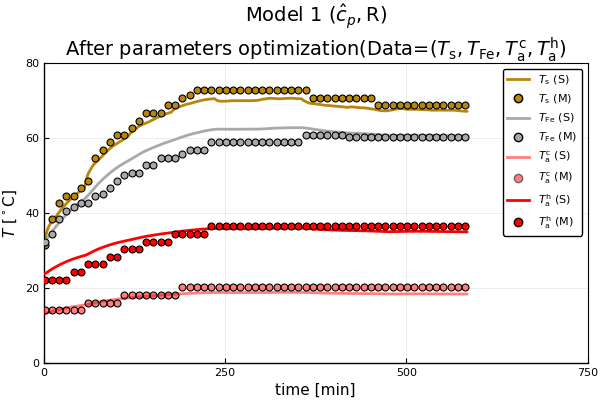

In [56]:
# Using data = (Ts,TFe,Tac,Tah)
# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model1 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()));
mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
unoptimized = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model1 = @. res_model1.minimizer*unoptimized;

# setting optimized parameter and solving ODE
p = res_model1.minimizer
prob = ODEProblem(gen,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1afterUsingDataTsTFeTacTad=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization(Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T_\\mathrm{a}^\\mathrm{c},T_\\mathrm{a}^\\mathrm{h}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)


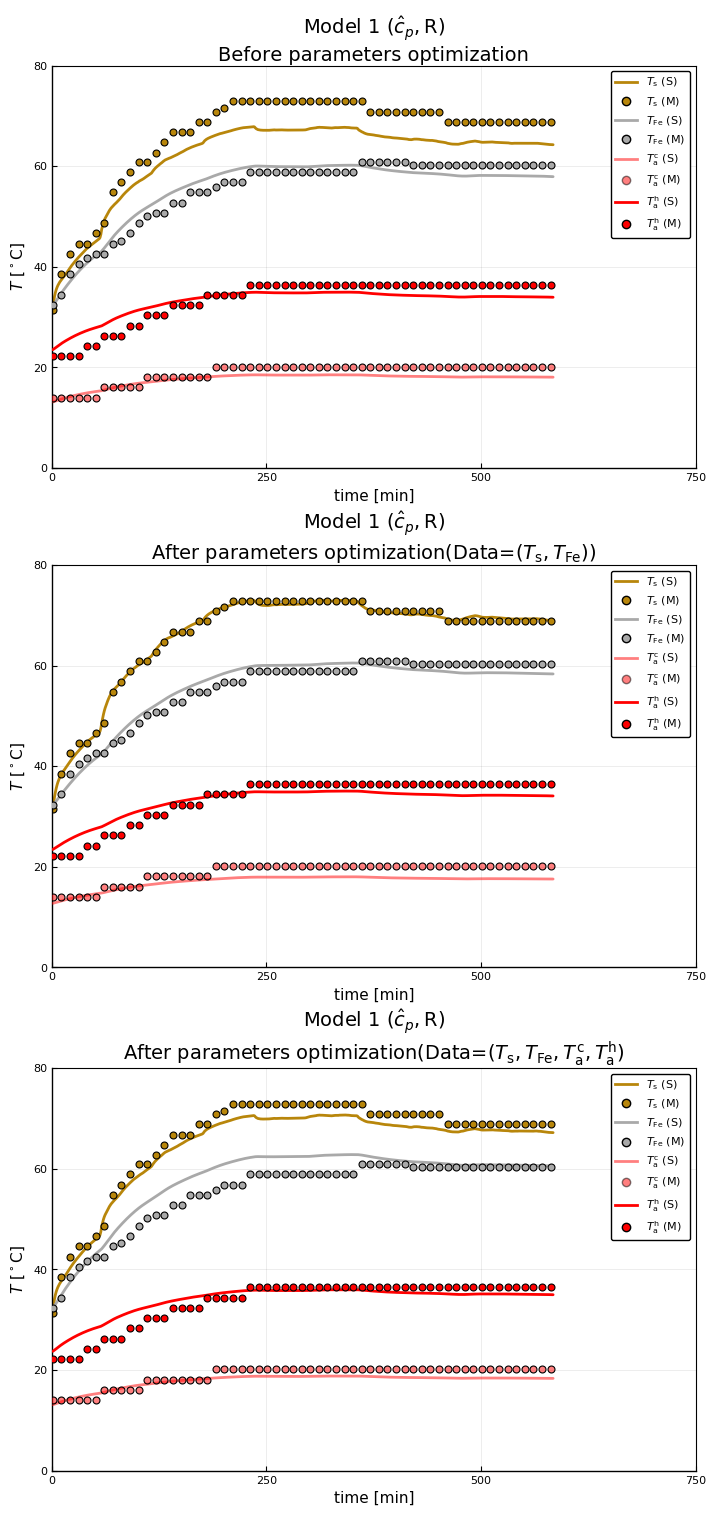

In [57]:
# Plotting befor and after together
figpath = "C:/Users/pande/Desktop/WorkiingDirectory/SummerJob2019/Figures/paramteropt/"
plot(Model1before,Model1afterUsingDataTsTFe,Model1afterUsingDataTsTFeTacTad,layout=grid(3,1),size = (700, 1500))
figfile = "model1beforafterparamteropt.svg"
savefig(figpath*figfile)


In [15]:
# Visualizing each parameters to have either optimum value or not for model1
# custom cost_function
function cost(par,idx)
    p = fill(1.,14)
    tspan=(0,583*60.)
    p[idx] .= par
    prob = ODEProblem(gen,u0,tspan,p)
    sol = solve(prob,Euler(), dt=60)#saveat=dt)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data)^2/2/N
end

cost (generic function with 1 method)

In [35]:
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
dt = 60
using Plots.PlotMeasures
pyplot()
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
labels = ["\$m_\\mathrm{r}^*\$","\$m_\\mathrm{s}^*\$","\$m_\\mathrm{Fe}^*\$",
    "\$R_\\mathrm{r}^*\$","\$R_\\mathrm{s}^*\$","\$\\mathcal{U}A^*_\\mathrm{r2\\delta}\$","\$\\mathcal{U}A^*_\\mathrm{s2Fe}\$",
    "\$\\mathcal{U}A^*_\\mathrm{Fe2a}\$","\$\\mathcal{h}A^*_\\mathrm{ax}\$","\$\\mathcal{h}A^*_\\mathrm{wx}\$",
    "\$\\dotQ^{\\sigma*}_\\mathrm{Fe}\$","\$\\dotW^*_\\mathrm{f}\$","\$\\dotm^*_\\mathrm{a}\$","\$\\dotm^*_\\mathrm{w}\$"]
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:14
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end

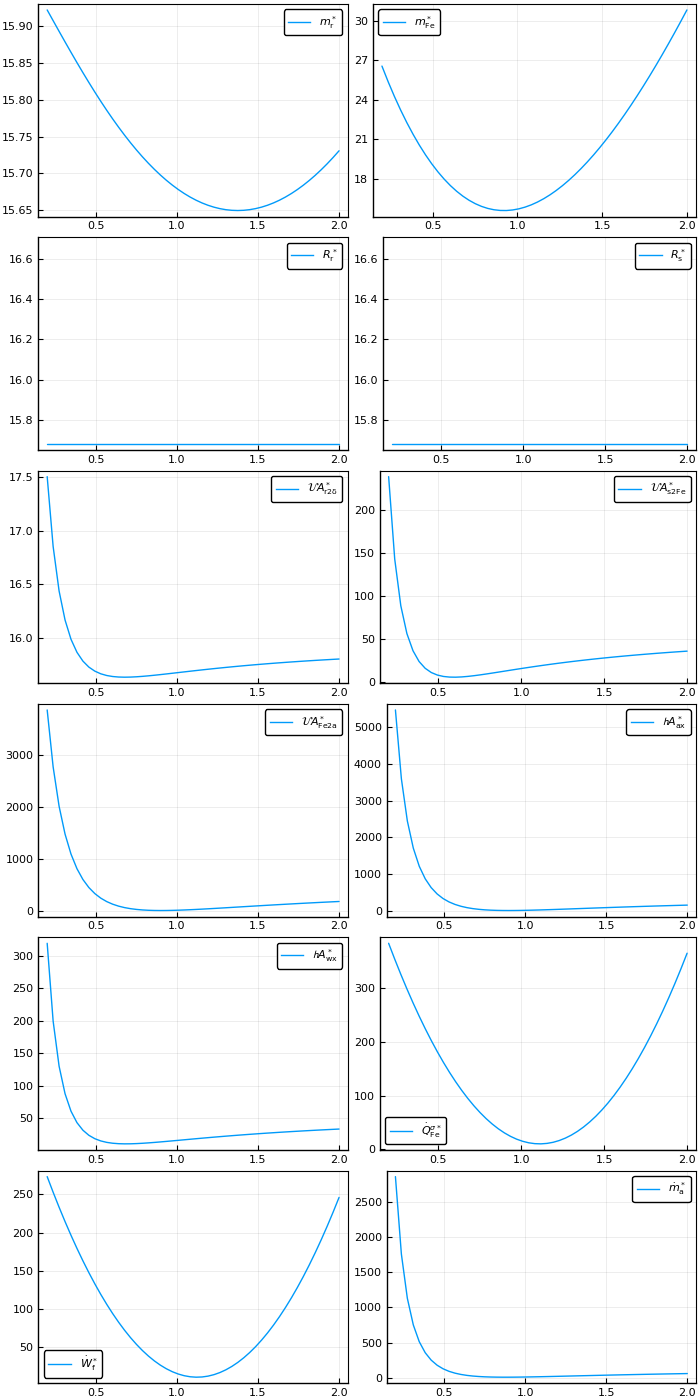

In [37]:
#fg = push!(fg,plot())
#plot(fg...,layout=(7,2),size=(700,1400),framestyle=:box,ylabel="Errors",
    #xlabel="Value",lw=2,lc=:blue,legend=:topright,bottom_margin=10mm,right_margin=10mm,title="Using Data=(\$T_\\mathrm{s},T_\\mathrm{Fe},T_\\mathrm{a}^\\mathrm{c},T_\\mathrm{a}^\\mathrm{h}\$)")
#figfile = "EachParamUsing4data"
#savefig(figpath*figfile)
plot(fg[1],fg[3],fg[4],fg[5],fg[6],fg[7],fg[8],fg[9],fg[10],fg[11],fg[12],fg[13],layout=(6,2),framestyle=:box,size=(700,1400))
#plot(fg[8],framestyle=:box,size=(500,500))

In [51]:
# using only Ts and TFe data
# custom cost_function
dataTwo = [data[1,:] data[2,:]]'

2×584 Adjoint{Float64,Array{Float64,2}}:
 31.4186  32.3701  32.9818  34.4092  …  68.8184  68.8184  68.8184  68.8184
 32.3701  32.3701  32.3701  32.3701     60.3393  60.3393  60.3393  60.3393

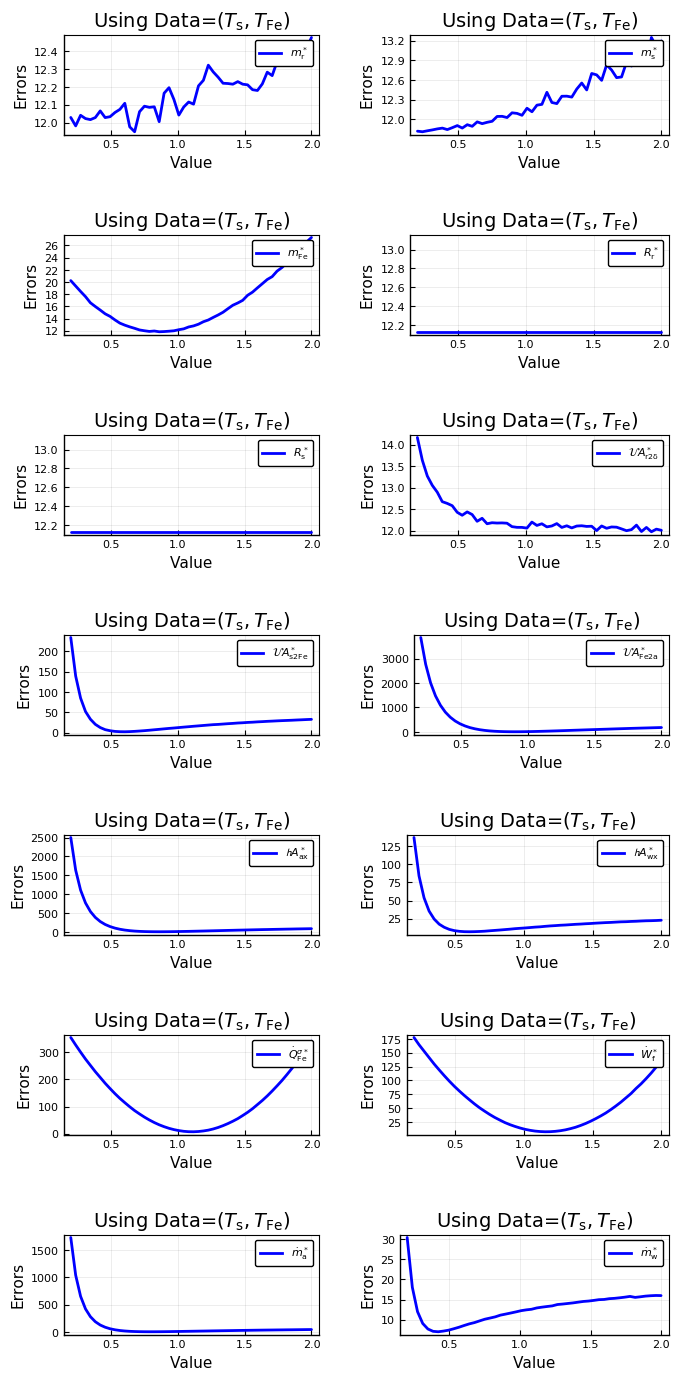

In [52]:
function cost(par,idx)
    p = fill(1.,14)
    tspan=(0,583*60.)
    p[idx] .= par
    prob = ODEProblem(gen,u0,tspan,p)
    sol = solve(prob, saveat=dt)
    Sol = reduce(hcat,sol.u)
    sim = [Sol[2,:]'; Sol[3,:]']
    return norm(sim-dataTwo)^2/2/N
end
 p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
#
using Plots.PlotMeasures
pyplot()
pp = range(0.2,2,length=50)
loss = (par) -> cost(par,[1])
fg = [plot(pp,loss.(pp),label=labels[1])]
for i in 2:14
    idx = [i]
    loss = (par) -> cost(par,idx)
    push!(fg,plot(pp,loss.(pp),label=labels[i]))
end
#fg = push!(fg,plot())
plot(fg...,layout=(7,2),size=(700,1400),framestyle=:box,ylabel="Errors",
    xlabel="Value",lw=2,lc=:blue,legend=:topright,bottom_margin=10mm,right_margin=10mm,title="Using Data=(\$T_\\mathrm{s},T_\\mathrm{Fe}\$)")
figfile = "EachParamUsing2data"
savefig(figpath*figfile)



# Model 2 starts

In [9]:
# Model 2
function gen2(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25. 
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*(1+alphaCu*(Tr-TCu_o))*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*chpCu)
    du[2] = (3*Rs*(1+alphaCu*(Ts-TCu_o))*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*chpCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*chpFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*chpa*(Tac-Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*chpa*(Tad-Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
prob = ODEProblem(gen2,u0,tspan,p)
sol = solve(prob, ABM54(), dt=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)

idx = 1:10:N
# Plotting simulation versus measurement data for Model 2
plt = plot()
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model2before=plot!(title="Model 2 (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen2,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model2 = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
unoptimized = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model2 = @. res_model2.minimizer*unoptimized
res_model2.minimizer

14-element Array{Float64,1}:
 1.0003467493020821
 0.8355699342238118
 1.002177246011223 
 1.000021222218909 
 1.000021222218909 
 1.0001126885020988
 1.0164780853748567
 1.0099558949003655
 1.00626782677168  
 1.0015956416517164
 0.9900292500261493
 0.992306147523958 
 1.0066425846966405
 1.0007072160260853

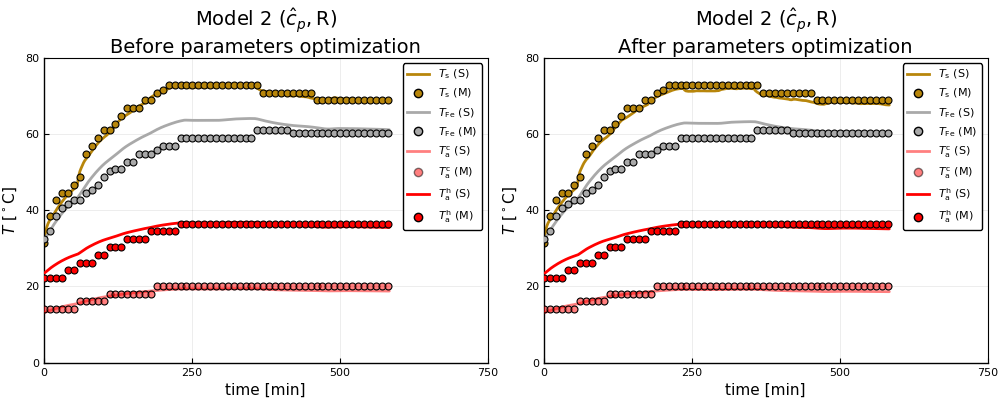

In [10]:
# setting optimized parameter and solving ODE
p = res_model2.minimizer
prob = ODEProblem(gen2,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model2after=plot!(title="Model 2 (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)
# Plotting befor and after together
plot(Model2before,Model2after,layout=grid(1,2),size = (1000, 400))

# Model 3a starts

In [11]:
# Model 3a
function gen3a(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*R*(aCu+bCu*Tr)/MCu)
    du[2] = (3*Rs*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*R*(aCu+bCu*Ts)/MCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*R*(aFe+bFe*TFe)/MFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    # Auxiliary parameters
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
prob = ODEProblem(gen3a,u0,tspan,p)
sol = solve(prob, ABM54(), dt=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)

idx = 1:10:N
# Plotting simulation versus measurement data for Model 2
plt = plot()
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3abefore=plot!(title="Model 3a (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen3a,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model3a = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
unoptimized = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model3a = @. res_model3a.minimizer*unoptimized
res_model3a.minimizer

14-element Array{Float64,1}:
 1.0101022811425258
 0.9915807954896513
 1.0176524732032597
 1.000008954610513 
 1.000008954610513 
 0.9980966727797317
 0.6046943046071462
 1.0387997813094019
 1.0352425434087669
 1.0031229741054695
 0.9519589020238344
 0.960323752097925 
 1.023623133743533 
 1.0048841341877977

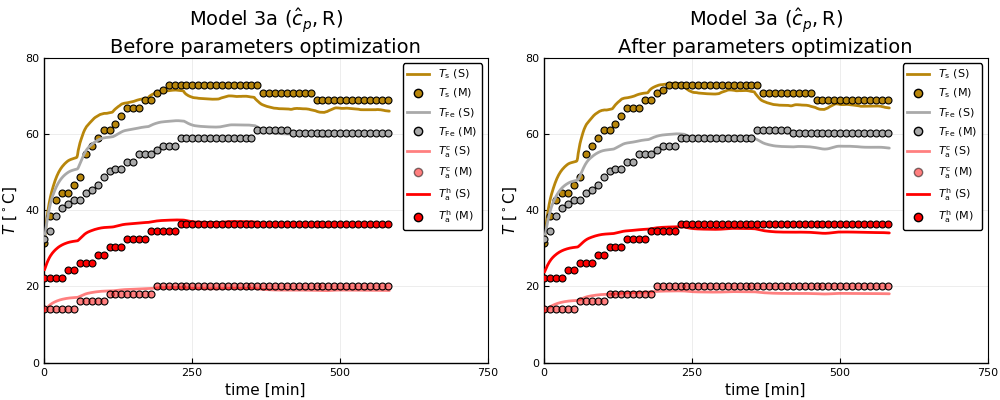

In [12]:
# setting optimized parameter and solving ODE
p = res_model3a.minimizer
prob = ODEProblem(gen3a,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3aafter=plot!(title="Model 3a (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)
# Plotting befor and after together
plot(Model3abefore,Model3aafter,layout=grid(1,2),size = (1000, 400))

# Model 4a starts

In [ ]:
# Model 4a
function gen4a(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    # Auxiliary parameters
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*(1+alphaCu*(Tr-TCu_o))*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*R*(aCu+bCu*Tr)/MCu)
    du[2] = (3*Rs*(1+alphaCu*(Ts-TCu_o))*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*R*(aCu+bCu*Ts)/MCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*R*(aFe+bFe*TFe)/MFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NhAax,NhAwx,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o = 1.012,4.1813,0.385,0.412,28.,0.00404,25.
    # Auxiliary parameters
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    UAx = 1/(1/(NhAax*hAax)+1/(NhAwx*hAwx))
    Qdfs = 0.8*(NWdf*Wdf)
    # Stanton numbers
    NSta = UAx/chpa/(Nmda*mda)
    NStw = UAx/chpw/(Nmdw*mdw)
    NStd = NStw - NSta
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
prob = ODEProblem(gen4a,u0,tspan,p)
sol = solve(prob, ABM54(), dt=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)

idx = 1:10:N
# Plotting simulation versus measurement data for Model 4a
plt = plot()
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4abefore=plot!(title="Model 4a (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen4a,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model4a = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

In [17]:
mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
unoptimized = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model4a = @. res_model4a.minimizer*unoptimized
res_model4a.minimizer

14-element Array{Float64,1}:
 1.0022083779164186
 1.0484677522229389
 1.019274341836814 
 1.0000100405291408
 1.0000100405291408
 1.0018595086187276
 0.754698267780307 
 1.1086063167446405
 1.0494168437266107
 1.0245796508065916
 0.8803935087270255
 0.9377902387728132
 1.0429044719035987
 1.0141573802944461

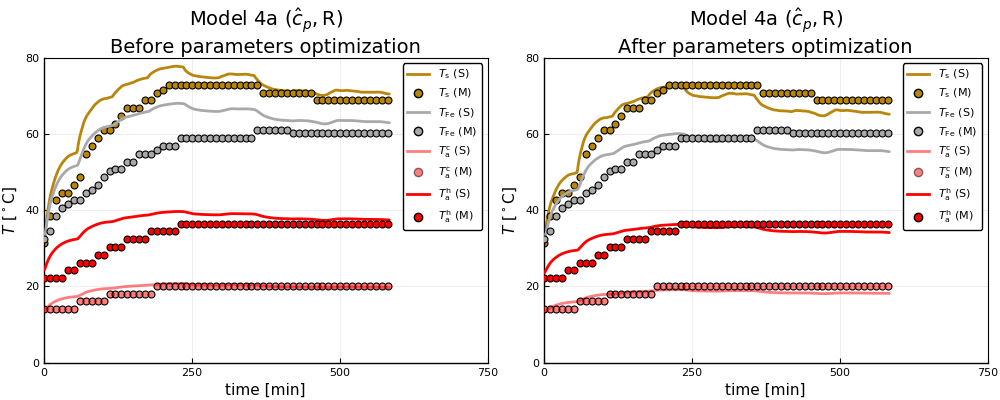

In [14]:
# setting optimized parameter and solving ODE
p = res_model4a.minimizer
prob = ODEProblem(gen4a,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4aafter=plot!(title="Model 4a (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)
# Plotting befor and after together
plot(Model4abefore,Model4aafter,layout=grid(1,2),size = (1000, 400))

# Model 3b starts

In [47]:
# Model 3b
function gen3b(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o,Up = 1.012,4.1813,0.385,0.412,28.,0.00404,25.,44.46
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    # Auxiliary parameters
    Qdfs = 0.8*(NWdf*Wdf)
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,1.)
        par = 1.
        function heat_exchanger!(dT,T,par,t)
            # Counter-current 
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*Nmda*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*Nmdw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,3.8]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-3.8
        end
        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(1) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
        #F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*R*(aCu+bCu*Tr)/MCu)
    du[2] = (3*Rs*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*R*(aCu+bCu*Ts)/MCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*R*(aFe+bFe*TFe)/MFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    par=1.
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o,Up = 1.012,4.1813,0.385,0.412,28.,0.00404,25.,44.46
    # Auxiliary parameters
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    Qdfs = 0.8*(NWdf*Wdf)
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,1.)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current 
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*Nmda*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*Nmdw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc[iterator]]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc[iterator]
        end
        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(1) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

alg_var (generic function with 1 method)

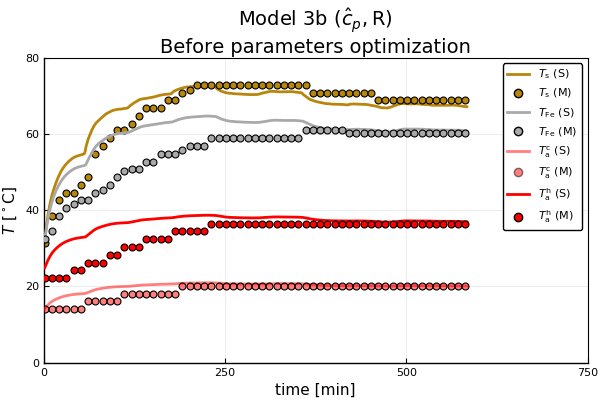

In [71]:
u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
prob = ODEProblem(gen3b,u0,tspan,p)
sol = solve(prob, ABM54(), dt=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)

idx = 1:10:N
# Plotting simulation versus measurement data for Model 2
plt = plot()
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3bbefore=plot!(title="Model 3b (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

In [ ]:
# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen3b,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model3b = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
unoptimized = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model3b = @. res_model3b.minimizer*unoptimized
res_model3b.minimizer

In [ ]:
# setting optimized parameter and solving ODE
p = res_model3b.minimizer
prob = ODEProblem(gen3b,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3bafter=plot!(title="Model 3b (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)
# Plotting befor and after together
plot(Model3bbefore,Model3bafter,layout=grid(1,2),size = (1000, 400))

# Model 4b starts

In [65]:
# Model 4b
function gen4b(du,u,p,t)
    # unpacking states
    Tr,Ts,TFe = u
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o,Up = 1.012,4.1813,0.385,0.412,28.,0.00404,25.,44.46
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    # Auxiliary parameters
    Qdfs = 0.8*(NWdf*Wdf)
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,1.)
        par = 1.
        function heat_exchanger!(dT,T,par,t)
            # Counter-current 
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*Nmda*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*Nmdw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,3.8]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-3.8
        end
        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(1) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
        #F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*u_Twc(t)
    end
    air_temp = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    Tac,Tad,Tah = air_temp
    # Forward Euler solver for ODE
    du[1] = (1.1*Rr*(1+alphaCu*(Tr-TCu_o))*u_Ifd(t)^2-NUAr2d*UAr2d*(Tr-Tad))/(Nmr*mr*R*(aCu+bCu*Tr)/MCu)
    du[2] = (3*Rs*(1+alphaCu*(Ts-TCu_o))*u_It(t)^2-NUAs2Fe*UAs2Fe*(Ts-TFe))/(Nms*ms*R*(aCu+bCu*Ts)/MCu)
    du[3] = (NUAs2Fe*UAs2Fe*(Ts-TFe)-NUAFe2a*UAFe2a*(TFe-Tah)+NQdFes*QdFes)/(NmFe*mFe*R*(aFe+bFe*TFe)/MFe)
end
# The following function finds values for algebraic variables as we
# do not have access using coustom ODE in Julia to access algebraic variable
# DAE would help but its tedious unlike ODE due to algebraic variables initial values
function alg_var(p,Sol)
    # Default parameters
    mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
    par=1.
    # Normalized parameters values
    Nmr,Nms,NmFe,NRr,NRs,NUAr2d,NUAs2Fe,NUAFe2a,NQdFes,NWdf,Nmda,Nmdw = p
    # constants specific heat capacities
    chpa,chpw,chpCu,chpFe,Ta_o,alphaCu,TCu_o,Up = 1.012,4.1813,0.385,0.412,28.,0.00404,25.,44.46
    # Auxiliary parameters
    R,MCu,MFe,Ma,Mw = 8.314,63.54,55.84,28.97,18.01
    # Linear approximation of NASA lewis coefficients
    aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
    Qdfs = 0.8*(NWdf*Wdf)
    algVar = zeros(3,N)
    x_initial = [28.,Ts_m[1],TFe_m[1]]
    iterator = 1
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z
        Tr,Ts,TFe = x_initial
        F[1] = Nmda*mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+NUAr2d*UAr2d*(Tr-Tad)+Qdfs
        F[2] = Nmda*mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+NUAFe2a*UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,1.)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current 
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*Nmda*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*Nmdw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc[iterator]]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc[iterator]
        end
        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(1) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    for iterator in 1:N
        x_initial = Sol[:,iterator]
        algVar[:,iterator] = nlsolve(algebraic_equation_solver!,x_initial).zero 
    end
    return algVar
end

u0 = [28.,Ts_m[1],TFe_m[1]]
# Time span
tspan = (0, 60*583.)
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
prob = ODEProblem(gen4b,u0,tspan,p)
sol = solve(prob, ABM54(), dt=60);
#
Sol = reduce(hcat,sol.u)
# find alg. variables
algVar=alg_var(p,Sol)

idx = 1:10:N
# Plotting simulation versus measurement data for Model 2
plt = plot()
plot!(plt,sol[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4bbefore=plot!(title="Model 4b (\$\\hatc_p,\\mathrm{R}\$)\nBefore parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)

# custom cost_function
function cost(p,gen_r,x0_r,tspan_r,dt_r,data_r)
    prob = ODEProblem(gen_r,x0_r,tspan_r,p)
    sol = solve(prob, saveat=dt_r)
    Sol = reduce(hcat,sol.u)
    algVar = alg_var(p,Sol)
    # finding algebraic variable for solving
    sim = [Sol[2,:]'; Sol[3,:]';algVar[1,:]';algVar[3,:]']
    return norm(sim-data_r)^2/length(sim)
end
# Initial value of loss function
loss = (p) -> cost(p,gen4b,u0,tspan,dt,data)
# Saving solution at 1 min
dt = 60.
# p = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
p = [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.] 
# param bounds
low_p = 0.1*p
high_p = 3*p
# result of optimization
res_model4b = optimize(loss,low_p,high_p,p,Fminbox(GradientDescent()))

mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw = 9260.,6827.,
        71200., 0.127e-3,1.95e-6 ,2.7,20,14.3,55.6,222., 212.,528., 53.9, 49.2
unoptimized = [mr,ms,mFe,Rr,Rs,UAr2d,UAs2Fe,UAFe2a,hAax,hAwx,QdFes,Wdf,mda,mdw]
optimized_model4b = @. res.minimizer*unoptimized
res_model4b.minimizer

MethodError: MethodError: no method matching +(::Array{Float64,1}, ::Int64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:502
  +(!Matched::Complex{Bool}, ::Real) at complex.jl:292
  +(!Matched::Missing, ::Number) at missing.jl:93
  ...

In [ ]:
# setting optimized parameter and solving ODE
p = res_model4b.minimizer
prob = ODEProblem(gen4b,u0,tspan,p)
# solution after optimized parameters
sol_after = solve(prob, ABM54(), dt=60);
Sol = reduce(hcat,sol_after.u)
algVar=alg_var(p,Sol)

plt = plot()
plot!(plt,sol_after[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,sol_after[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,algVar[1,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

plot!(plt,algVar[3,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4bafter=plot!(title="Model 4b (\$\\hatc_p,\\mathrm{R}\$)\nAfter parameters optimization",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,750),ylim=(0,80),framestyle = :box, legend=:topright)
# Plotting befor and after together
plot(Model4bbefore,Model4bafter,layout=grid(1,2),size = (1000, 400))